In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ImageFolder():
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        with open(labels_filepath, 'rb') as file:
            file.read(8)
            labels = np.fromfile(file, dtype=np.uint8)

        with open(images_filepath, 'rb') as file:
            file.read(16)
            image_data = np.fromfile(file, dtype=np.uint8)

        num_images = labels.shape[0]
        image_size = 28

        images = []
        for i in range(num_images):
            img = image_data[i * image_size * image_size:(i + 1) * image_size * image_size]
            img = img.reshape((image_size, image_size))
            images.append(img)

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

In [3]:
dataset = '/kaggle/input/mnist-dataset'

In [4]:
training_images_file_path = os.path.join(dataset, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_images_label_path = os.path.join(dataset, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
testing_images_file_path = os.path.join(dataset, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
testing_images_label_path = os.path.join(dataset, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [5]:
imfolder = ImageFolder(training_images_file_path, training_images_label_path, testing_images_file_path, testing_images_label_path)

In [6]:
train_data, test_data = imfolder.load_data()

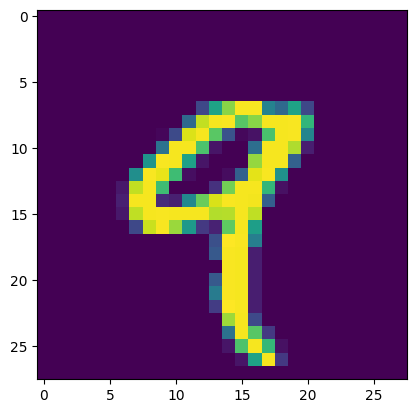

In [7]:
plt.imshow(train_data[0][4])

In [8]:
class OneHotEncoding:
    def __init__(self):
        pass
    
    def encode(self, label, num_classes):
        return np.eye(num_classes)[label]
    
    def decode(self, label):
        return np.argmax(label, axis = 1)

In [9]:
class DataLoader():
    def __init__(self, dataset, batch_size = 32, shuffle = False, drop_last = False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.num_samples = len(dataset[0])
        
        self.indices = np.arange(self.num_samples)
        
        self.onehot = OneHotEncoding()
        
        if self.shuffle:
            np.random.shuffle(self.indices)    
    
    def __iter__(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
        
        for start in range(0, self.num_samples, self.batch_size):
            end = start + self.batch_size
            
            if self.drop_last and end > self.num_samples:
                break
            
            batch_indices = self.indices[start:end]
            
            yield self.collate_fn(batch_indices)
    
    def collate_fn(self, batch_indices):
        images = np.array(self.dataset[0])[batch_indices]
        labels = self.onehot.encode(np.array(self.dataset[1])[batch_indices], 10)
        return images, labels

In [45]:
class Linear:
    def __init__(self, in_features, out_features, bias = True):
        
        k = 1 / np.sqrt(in_features) 

        self.weights = np.random.uniform(-k, k, (out_features, in_features))
        self.bias = np.random.uniform(-k, k, out_features) if bias else np.zeros(out_features)
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_bias = np.zeros_like(self.bias) 
        
    def forward(self, x):
        return np.dot(x, self.weights.T) + self.bias
    
def ReLU(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exps = np.exp(x)
    
    return exps / np.sum(exps, axis = 1, keepdims = True)

In [46]:
class NLLLoss:
    def __init__(self):
        pass
        
    def loss(self, output, targets):
        epsilon = 1e-12
        output = np.clip(output, epsilon, 1. - epsilon)
        return - np.sum(targets * np.log(output))

    def backward(self, output, targets):
        epsilon = 1e-12
        output = np.clip(output, epsilon, 1. - epsilon)
        return output - targets


In [47]:
class MLP:
    def __init__(self, activation=sigmoid, lr = 1e-4):
        self.linear1 = Linear(28*28, 200)
        self.linear2 = Linear(200, 10)
        self.activation = activation
        self.softmax = softmax
        
        self.criterion = NLLLoss()
        
        self.lr = lr
        
    def forward(self, x):
        self.hidden = self.linear1.forward(x)
        self.activated = self.activation(self.hidden)
        self.output = self.linear2.forward(self.activated)
        self.probabilities = self.softmax((self.output))
        
        return self.probabilities
    
    def fit(self, train_dl, num_epochs):
        total_accuracy = []
        total_loss = []
        for epoch in range(num_epochs):
            epoch_accuracy = 0.0
            epoch_loss = 0.0
            total_items = 0
            
            for idx, data in enumerate(train_dl):
                images, labels = data

                flatten_imgs = images.reshape(images.shape[0], -1)
                
                output = self.forward(flatten_imgs)
                
                loss = self.criterion.loss(output, labels)
                
                self.zero_grad()
                
                self.backward(output, labels, flatten_imgs)
                
                self.step()
                
                predict = np.argmax(output, axis=1)
                
                epoch_loss += loss
                
                decoded_labels = train_dl.onehot.decode(labels)
                
                accuracy = (predict == decoded_labels).sum()
                
                epoch_accuracy += accuracy
                total_items += len(images)
            
            epoch_accuracy = epoch_accuracy / total_items
            total_accuracy.append(epoch_accuracy)
            
            epoch_loss = epoch_loss / total_items
            total_loss.append(epoch_loss)
            
            print(f'Epoch: {epoch + 1} Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.2f}')
        
        self.train_accuracy = total_accuracy
        self.train_loss = total_loss
        return total_accuracy, total_loss   
    
    def test(self, test_dl):
        result = {}
        result['images'] = []
        result['labels'] = []
        result['accuracy'] = .0
        result['inference'] = []
        total_items = 0
        
        for data in test_dl:
            img, labels = data
            
            result['images'].append(img)
            
            flatten_imgs = img.reshape(img.shape[0], -1)
            
            output = self.forward(flatten_imgs)
            
            output = np.argmax(output, axis = 1)
            
            total_items += len(img)
            
            decoded_labels = test_dl.onehot.decode(labels)
            
            correct = (output == decoded_labels).sum()
            
            result['labels'].append(decoded_labels)
            result['inference'].append(output)
            result['accuracy'] += correct
            
        result['accuracy'] = result['accuracy'] / total_items
        return result
    
    def backward(self, output, labels, inputs):
        batch_size = output.shape[0]
        grad_output = self.criterion.backward(output, labels)
        
        grad_hidden = np.dot(grad_output, self.linear2.weights)
        
        sigmoid_grad = self.activated * (1 - self.activated)
        grad_hidden *= sigmoid_grad
        
        self.linear2.grad_weights = np.dot(grad_output.T, self.activated) / batch_size
        self.linear2.grad_bias = np.sum(grad_output, axis=0) / batch_size
        
        self.linear1.grad_weights = np.dot(grad_hidden.T, inputs) / batch_size
        self.linear1.grad_bias = np.sum(grad_hidden, axis=0) / batch_size
    
    def parameters(self):
        return [(self.linear1.weights, self.linear1.grad_weights),
                (self.linear1.bias, self.linear1.grad_bias),
                (self.linear2.weights, self.linear2.grad_weights),
                (self.linear2.bias, self.linear2.grad_bias)]
        
    def step(self):
        self.linear1.weights -= self.lr * self.linear1.grad_weights
        self.linear1.bias -= self.lr * self.linear1.grad_bias
        
        self.linear2.weights -= self.lr * self.linear2.grad_weights
        self.linear2.bias -= self.lr * self.linear2.grad_bias
        
    def zero_grad(self):
        self.linear1.grad_weights.fill(0)
        self.linear1.grad_bias.fill(0)
        
        self.linear2.grad_weights.fill(0)
        self.linear2.grad_bias.fill(0)



In [48]:
train_dl = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dl = DataLoader(test_data, batch_size = 32)

model = MLP()

accuracy, loss = model.fit(train_dl, num_epochs = 5)

result = model.test(test_dl)

Epoch: 1 Loss: 2.0607 Accuracy: 0.39
Epoch: 2 Loss: 1.6912 Accuracy: 0.65
Epoch: 3 Loss: 1.4523 Accuracy: 0.72
Epoch: 4 Loss: 1.2824 Accuracy: 0.76
Epoch: 5 Loss: 1.1530 Accuracy: 0.79


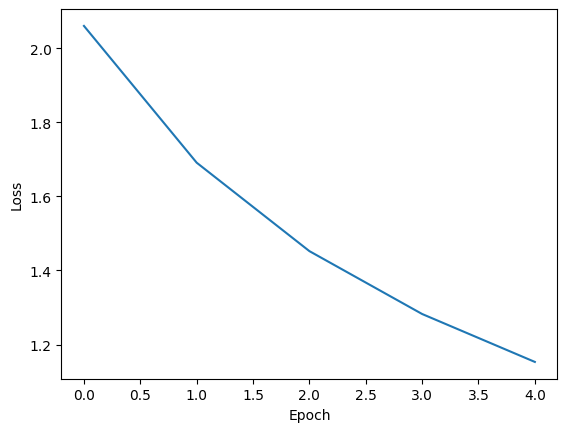

In [49]:
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [50]:
print(f'Test Accuracy: {result["accuracy"]:.2f}')

Test Accuracy: 0.81


In [51]:
def show_result(image, label, inference):
    print(f'Target: {label} Inference: {inference}')
    if inference == label:
        print('Correct inference')
    else:
        print('Incorrect inference')
    plt.imshow(image)
    

Target: 7 Inference: 7
Correct inference


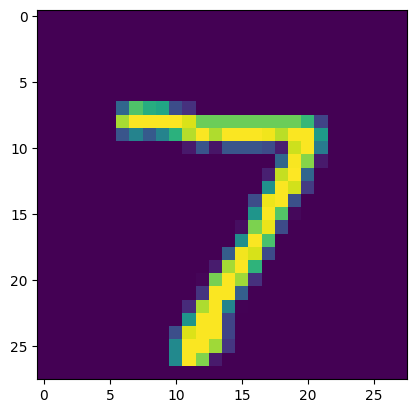

In [52]:
show_result(result['images'][0][0], result['labels'][0][0], result['inference'][0][0])